In [1]:
# Exploring the adult data set from the UCI repository.
# Download the files adult.data and adult.test
# from https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
import adult
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from forest_clusters import ForestClusters, buckets, total_variation
from display_cluster import display_cluster, CompressedForest

# First, let's import the adult data set and clean it up

original = adult.original
categorical = [col for col in original.columns 
               if ~np.issubdtype(original[col], np.number)]
original[categorical] = original[categorical].fillna(value = 'None')

# Make sex a boolean feature
sanitized = original[original.columns.difference(['Target', 'Sex'])]
sanitized = sanitized.assign(Male = original['Sex'] == 'Male')

X = pd.get_dummies(sanitized)
y = adult.labels

In [2]:
# Train a random forest model for binary classification.
# The forest is a set of decision trees. Given a point, each tree
# casts a vote for whether the point should go in the positive class.
# The final decision is done by majority voting.

original_train, original_test, X_train, X_test, y_train, y_test = train_test_split(original, X, y, train_size=0.7)

forest = RandomForestClassifier(n_estimators = 30, max_depth = 8, min_samples_leaf = 20)
forest = forest.fit(X_train, y_train)

print("Train score %f" % forest.score(X_train, y_train))
print("Test score %f" % forest.score(X_test, y_test))

/home/arthur/env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train score 0.851941
Test score 0.853750


In [3]:
# We work with data points in a transformed space of tree paths.
# Given a point, we compute the vector of leaf nodes that the point
# reached on each tree, under a one-hot encoding.
# Each leaf corresponds uniquely to a path traversed in the tree.

leaf_encoder = OneHotEncoder()
leaf_encoder = leaf_encoder.fit(forest.apply(X))
forest.apply(X)

array([[ 64, 154,  89, ...,  65,  45,  43],
       [ 15, 109,  57, ...,  42, 116,  12],
       [ 60,  83,  64, ...,  65,  42,  15],
       ...,
       [102, 117,  50, ..., 146, 133,  11],
       [ 75,  79,  50, ...,  18,  31,  62],
       [115, 117,  60, ..., 160, 123,  12]])

In [4]:
# We can then cluster these points according to this encoding.
# Agglomerative clustering seems to yield the best results so far,
# at least on this data set (it tends to work better with clusters of uneven
# size) 

n_clusters = 20
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
# clusters = KMeans(n_clusters = n_clusters)
# X_sample = X_train.sample(n = 1000)
# clusters = clusters.fit(leaf_encoder.transform(cforest.apply(X_sample)))
# clusters = clusters.predict(leaf_encoder.transform(cforest.apply(X_test)))
clusters = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'l1', linkage = 'average')
# clusters = DBSCAN(eps = 3, metric = 'l1')
X_test_leaves = leaf_encoder.transform(forest.apply(X_test))
clusters = clusters.fit_predict(X_test_leaves.toarray())

In [6]:
from display_cluster import display_cluster

def encode_features(original):
    return X.loc[original.index]

display_cluster(forest, original, original_test, y_test, 
                forest.apply(X_test), clusters, n_clusters,
                encode_features=encode_features)

,Size,Accuracy,Mean Votes
0,2082,0.958694,0.004259
1,350,0.805714,0.063048
2,4130,0.987651,0.001340
3,691,0.866860,0.024457
4,702,0.712251,0.221320
5,5,0.600000,0.486667
6,45,0.866667,0.060000
7,473,0.983087,0.752502
8,544,0.858456,0.039645
9,30,0.966667,0.503333


interactive(children=(BoundedIntText(value=0, description='Cluster', max=20), Dropdown(description='Column', o…

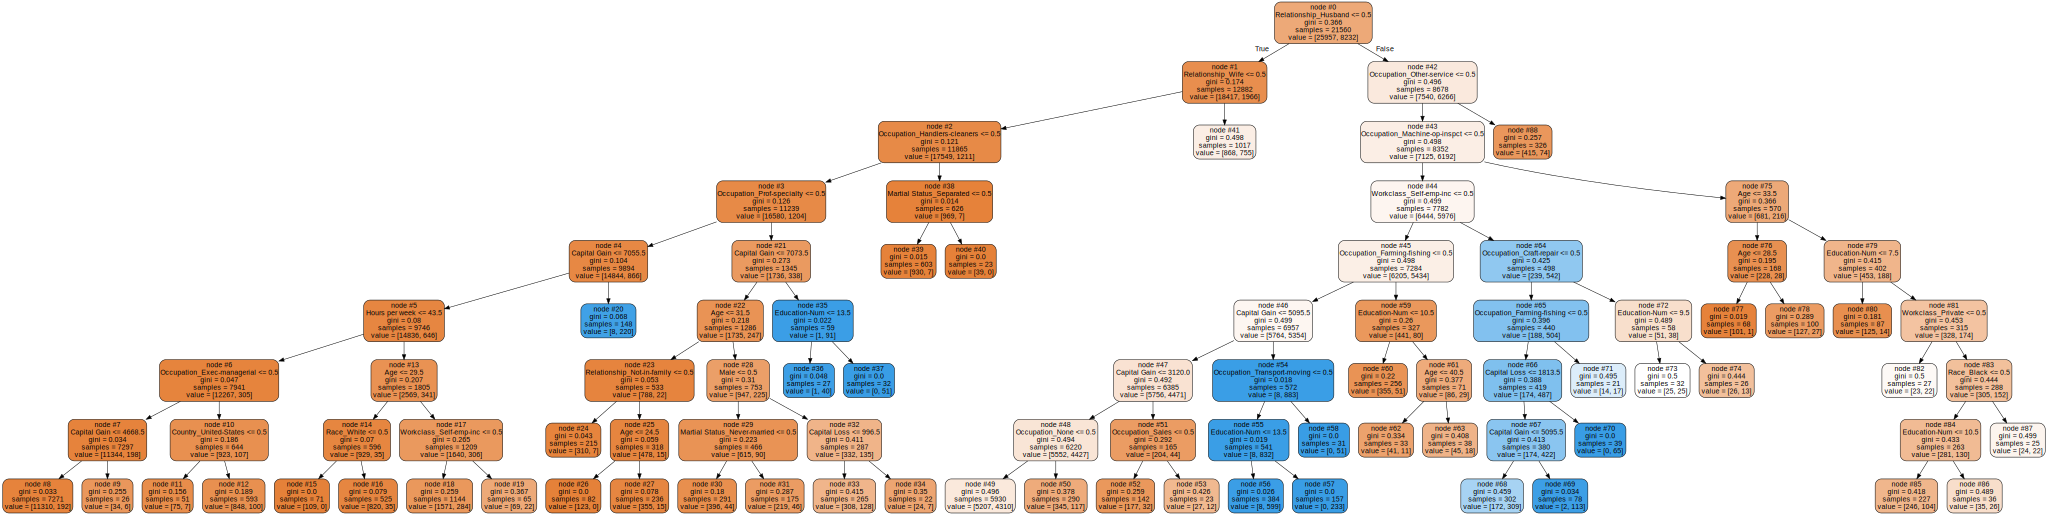

In [8]:
# The paths tends to have a lot of redundancy in terms
# of classification behavior

from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(forest.estimators_[3], 
                           feature_names = X_test.columns,
                           out_file = None, filled = True,
                           rounded = True, node_ids = True)
graph = graphviz.Source(dot_data)
graph

In [9]:
# Let us do the same thing, but this time compressing redundant paths

cforest = CompressedForest(forest)

cleaf_encoder = OneHotEncoder()
cleaf_encoder = cleaf_encoder.fit(cforest.apply(X))
cforest.apply(X)

array([[ 47, 153,  88, ...,  59,  27,  40],
       [  4, 109,  57, ...,  41, 111,  10],
       [ 47,  76,  62, ...,  59,  27,  13],
       ...,
       [102, 117,  48, ..., 145, 133,  10],
       [ 73,  76,  48, ...,   5,  27,  58],
       [115, 117,  58, ..., 160, 122,  10]])

In [11]:
cclusters = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'l1', linkage = 'average')
X_test_leaves = cleaf_encoder.transform(cforest.apply(X_test))
cclusters = cclusters.fit_predict(X_test_leaves.toarray())

In [12]:
display_cluster(forest, original, original_test, y_test, 
                cforest.apply(X_test), cclusters, n_clusters,
                encode_features=encode_features)

,Size,Accuracy,Mean Votes
0,773,0.866753,0.024623
1,13,0.692308,0.358974
2,473,0.983087,0.752502
3,49,0.877551,0.543537
4,112,0.526786,0.450000
5,6534,0.973370,0.003484
6,3965,0.726860,0.093493
7,40,0.900000,0.031667
8,24,0.958333,0.550000
9,614,0.718241,0.100217


interactive(children=(BoundedIntText(value=0, description='Cluster', max=20), Dropdown(description='Column', o…

In [138]:
c1 = original['Capital Gain'] >= 5500
p1 = original[c1]
c2 = original['Age'] <= 28
p2 = original[np.logical_and(np.logical_not(c1), c2)]
c3 = original['Relationship'] == 'Unmarried'
p3 = original[np.logical_and(np.logical_and(np.logical_not(c1), np.logical_not(c2)), c3)]

[(len(p1), p1['Target'].mean()),
 (len(p2), p2['Target'].mean()),
 (len(p3), p3['Target'].mean())]


[(2168, 0.9511070110701108),
 (13193, 0.03547335708330175),
 (4195, 0.054827175208581644)]

In [ ]:
# Measure cluster stability

from itertools import permutations

def cluster_distance(c1, c2):
    n_clusters = c1.clusters.n_clusters
    points = X.sample(n = 100)
    def permutation_distance(pi):
        p1 = c1.predict(points)
        p2 = np.vectorize(lambda k: pi[k])(c2.predict(points))
        return (p1 != p2).mean()
    return min(permutation_distance(pi)
               for pi in permutations(range(n_clusters)))

import operator

def greedy_cluster_distance(c1, c2):
    n_clusters = c1.clusters.n_clusters
    n_points = 100
    points = X.sample(n = n_points)
    weights = {(i, j): sum(np.logical_and(c1.predict(points) == i, 
                                          c2.predict(points) == j))
               for i in range(n_clusters) for j in range(n_clusters)}
    total_weight = n_points
    while len(weights) != 0:
        ((i, j), weight) = max(weights.items(), key=operator.itemgetter(1))
        total_weight = total_weight - weight
        weights = {(ii, jj): v for (ii, jj), v in weights.items() if ii != i and jj != j}
    return total_weight / n_points

def instability(n, samples):
    def it():
        c1 = ForestClusters(cforest, leaf_encoder, n_clusters = n)
        c1.fit(X_train.sample(n = 100))
        c2 = ForestClusters(cforest, leaf_encoder, n_clusters = n)
        c2.fit(X_train.sample(n = 100))
        return cluster_distance(c1, c2)
    return np.array([it() for k in range(samples)]).mean()

def greedy_instability(n, samples):
    def it():
        c1 = ForestClusters(cforest, leaf_encoder, n_clusters = n)
        c1.fit(X_train.sample(n = 100))
        c2 = ForestClusters(cforest, leaf_encoder, n_clusters = n)
        c2.fit(X_train.sample(n = 100))
        return greedy_cluster_distance(c1, c2)
    return np.array([it() for k in range(samples)]).mean()

# for k in range(2, 30):
#    print("%d | %.03f" % (k, greedy_instability(k, 15)))


4      6311
35     2870
144    1314
85      824
149     551
27      353
67      350
33      299
147     265
77      215
130     215
59      118
74      113
140      83
68       77
119      75
121      73
21       69
53       62
110      50
dtype: int64

4      5814
85      102
130      91
59       45
72        2
110       1
dtype: int64

4     431
59     43
73      4
dtype: int64

164    47
21     46
110    34
77     12
130    11
121     1
59      1
dtype: int64

35    2633
27     346
33     295
53      60
52      32
66      21
54      20
67       8
34       8
68       2
72       1
dtype: int64

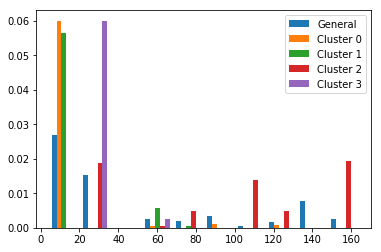

In [9]:
def compare_paths(tree, cluster_idx):
    fig = plt.figure()
    ax = plt.subplot()
    test_leaves = cforest.apply(X_test)
    test_clusters = clusters
    leaves_general = test_leaves[:,tree]
    leaves_clusters = [test_leaves[test_clusters == c, tree] for c in cluster_idx]
    ax.hist([leaves_general] + leaves_clusters, density = True,
             label = ['General'] + ['Cluster %d' % c for c in cluster_idx])
    ax.legend()
    display(pd.Series(leaves_general).value_counts(normalize = False).head(20))
    for leaves in leaves_clusters:
        display(pd.Series(leaves).value_counts(normalize = False).head(20))
        
compare_paths(18, [0, 1, 2, 3])